# Quickstart: Resilience and Change Point Analysis with *antiCPy*

Resilience analysis covers a variety of concepts and methods. This contribution aims to provide you with a basic introduction in how [*antiCPy*'s Langevin-based stability analysis](#resilienceanalysis) tools work. Additionally, we briefly consider how [*antiCPy*'s Bayesian change point fit](#CP) implementation and how it may be used to roughly infer time horizons of future destabilization and critical transitions. Finally, we summarize our [key takeaways](#summary). The classification of bifurcation types and stability analysis using delay embedding and eigenvalue estimation is treated in this [hands-on tutorial](https://anticpy.readthedocs.io/en/latest/early_warnings/dominant_eigenvalue/dominant_eigenvalue_tutorial.html) and the corresponding [math guide](https://anticpy.readthedocs.io/en/latest/early_warnings/dominant_eigenvalue/dominant_eigenvalue_maths.html).

## Contents

> 1. [Resilience Analysis](#resilienceanalysis)
> 2. [Trend-Change Point Analysis](#CP)
> 3. [Summary and Outlook](#summary)
> 4. [Excursion: Mathematical Model Insights](#excursion)

First, we load all necessary packages. Briefly, *antiCPy* relies on the efficient infrastructure of the [*numpy*](https://numpy.org/) package, complemented by the article [Array programming with NumPy](https://doi.org/10.1038/s41586-020-2649-2) (Harris et al., Nature (2020)). Furthermore, we want to visualize our results using *matplotlib*.

Tools to track a system's stability over time are collected in *antiCPy*'s `early_warnings` subpackage. Here, we aim to robustly quantify the resilience of a nonlinear system under (possibly correlated) noise. Therefore, we load the `drift_slope` module.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from antiCPy.early_warnings import drift_slope as ds

Next, we load some example data to analyse. For illustration purposes, we use a dataset simulated over the time interval $[0,2000]$ from the article [Bayesian on-line anticipation of critical transitions](https://doi.org/10.1088/1367-2630/ac46d4) (Heßler & Kamps, New J. Phys. (2022)). The true constant noise level of the data is $\sigma=0.25$.

Check for the number of observations:  (40000,)


Text(1450, 1.3, 'Critical transition')

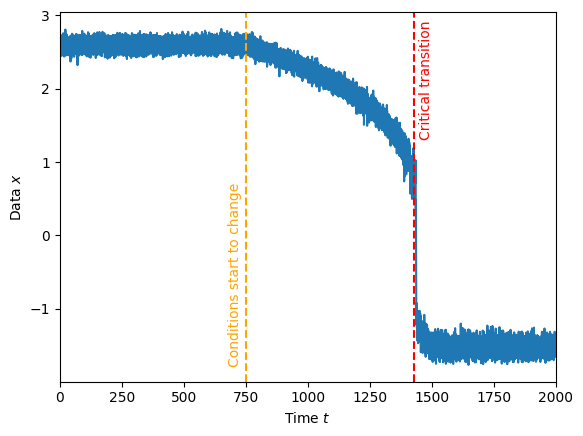

In [3]:
data = np.load('../tutorial_data/ts_fold_sigma0.25_cp_paper.npy')
time = np.linspace(0,2000,data.size)
print('Check for the number of observations: ', data.shape)

# Visualize the data
plt.plot(time, data)
plt.xlim(0, 2000)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Data $x$')
plt.axvline(750, c='orange', ls='--')
plt.text(680, -1.8, "Conditions start to change", rotation=90, c='orange', verticalalignment='bottom')
critical_time = 1429
plt.axvline(critical_time, c='red', ls='--')
plt.text(1450, 1.3, "Critical transition", rotation=90, c='red', verticalalignment='bottom')

We print the shape of the dataset and recognize that it contains $4{\cdot}10^4$ observations, before we visualize the data. In the first interval, the data fluctuate around a fixed average. This means the system is in a *stable state*, where conditions do not change over time. Around time $t\approx 750$ (orange dashed line), the system conditions begin to change slowly. For example, this could be the food availability in an ecological system, or the sea surface temperature in a climate system. Because the change is gradual, the system adjusts and tracks the new equilibrium. However, approximately at time $t\approx1429$ (red dashed line), the system abruptly jumps to another regime. This phenomenon is called a *critical transition*, in which the formerly stable state disappears, leaving only another stable state near $x\approx -1.5$. For a detailed mathematical discussion of the model, please refer to the [Excursion](#excursion).

## Resilience Analysis <a id="resilienceanalysis"></a>

Now, we can use *antiCPy* to quantify the stability of the system over time. Briefly, the data is modelled by deterministic slow-scale and stochastic fast-scale dynamics. The algorithm estimates the model's so-called *drift slope* $\zeta$ as a local measure of stability: negative and positive drift slopes indicate stable and unstable states, respectively. Its modulus determines the decay/growth rate (minus/plus sign) of fluctuations. By using *antiCPy*, we evaluate small data windows containing `window_size` data points to track stability over time. After computing a window, it is shifted by `window_shift`. Before analysing the data, we adjust it to make each time window roughly stationary. This allows us to focus on the local fluctuations without being biased by slow changes in the trend. In the code block below, we use *antiCPy*'s built-in Gaussian kernel detrending to subtract a smoothed slow trend from the raw data. Finally, we use a computationally lightweight maximum a posteriori (MAP) estimation to determine the drift slopes and noise levels over time. By default, half of the available CPU cores are occupied. You can change this by either using `'all'` or an integer number of cores. For a serial computation replace `fast_MAP_resilience_scan` by `perform_MAP_resilience_scan`. Depending on the number of available CPU cores, the following computations may take less than or a couple of minutes. We can compute fewer windows in total by increasing `window_shift` if we want to get a quick impression of *antiCPy*'s resilience analysis tools. In case we suspect the computation might be stuck, we can use `print_progress=True` to obtain a detailed output stream.

>💡 Multiprocessing is safely handled inside the package.  
> Only add a `if __name__ == "__main__":` block under the package imports if you run this code as a standalone Python script.




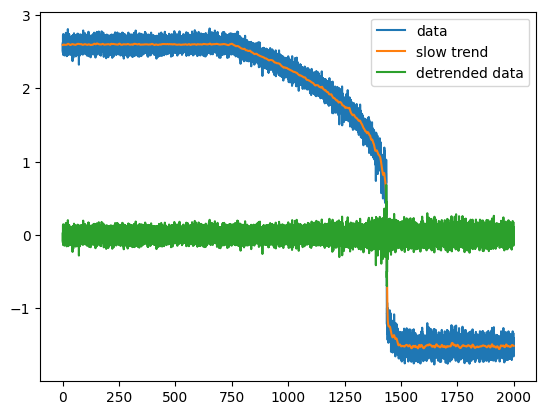

HINT: Fixed cred_percentiles = numpy.array[5,1]) for the uncorrelated Gaussian error propagation of the drift slope is used for drift_model == `3rd_order_polynomial`.
Start parallel processing!
Parallel processing finished!


In [4]:
window_size=2000
window_shift=200 # Increasing window_shift decreases the total number of windows computed, 
                 # thereby reducing the overall computation time of the code block.

langevin_model = ds.LangevinEstimation(data, time, detrending_of_whole_dataset='Gaussian kernel smoothed',
                                       gauss_filter_sigma=50, plot_detrending=True)

langevin_model.fast_MAP_resilience_scan(window_size=window_size, window_shift=window_shift, 
                                        error_propagation='uncorrelated Gaussian', print_progress=False)

First, we visualize the detrending for a sanity check by using `plot_detrending=True`. Here, we apply a trade-off between the smoothness and the correctness of the filtered slow trend in the transition area. If the kernel width (`Gaussian_kernel_sigma`) is chosen too large, the slow trend estimates smear out over the transition interval. Subtracting such an estimate would lead to biased estimates in this particular time interval. Next, *antiCPy* hints to credible intervals from 5-95% and 1-99%, as these percentiles are fixed, but can be arbitrarily chosen for other estimators. Once, we get the output that parallel processing has finished, we can define the custom plot function (first code block below) to visualize our results and compare the drift slopes and noise levels to the ground truths (second code block below).

In [5]:
def visualize_result(time, metric, window_size, window_shift, visualize):
    global critical_time
    
    mid_window = int(window_size/2.)
    
    if visualize=='drift slope':
        analytic_solution = np.load('../tutorial_data/unperturbed_drift_slopes_ts_fold_sigma0.25_cp_paper.npy')
        plt.plot(time, analytic_solution,color='k', ls=':', label = 'Ground truth')
        plt.plot([time[0], time[-1]], [0,0], color='red', ls=':')
        plt.axvspan(critical_time-mid_window*(time[1]-time[0]), critical_time+mid_window*(time[1]-time[0]),
                                              color = 'gray', alpha = 0.2, label = 'Window')
        plt.ylabel(r'Drift slope $\hat{\zeta}$')
        plt.axvline(750, c='orange', ls='--')
        plt.text(680, -14, "Conditions start to change", rotation=90, c='orange', verticalalignment='bottom')
        plt.axvline(critical_time, c='red', ls='--')
        plt.text(1450, -20, "Critical transition", rotation=90, c='red', verticalalignment='bottom')
    elif visualize=='noise level':
        plt.plot([time[0], time[-1]], [0.25,0.25], color='k', ls=':', label='Ground truth')
        plt.ylabel(r'Noise level $\hat{\sigma}$')
        plt.ylim(0,0.75)
    elif visualize=='both':
        print(np.array(metric[0]).shape)
        visualize_result(time, np.array(metric[0]), window_size, window_shift,visualize='drift slope')
        plt.figure()
        visualize_result(time, np.array(metric[1]), window_size, window_shift,visualize='noise level')
        return
    else:
        print('ERROR: The `visualize` option is not defined.')
        return
    
    plt.plot(time[mid_window:-mid_window:window_shift], metric[0,:])

    plt.fill_between(time[mid_window:-mid_window:window_shift], 
                     metric[1,:], metric[2,:], 
                     alpha=0.6, color='orange')
    
    plt.fill_between(time[mid_window:-mid_window:window_shift], 
                     metric[3,:], metric[4,:], 
                     alpha=0.4, color='orange')

    plt.xlabel(r'Time $t$')
    plt.xlim(time[0], time[-1])
    plt.legend()

(5, 190)


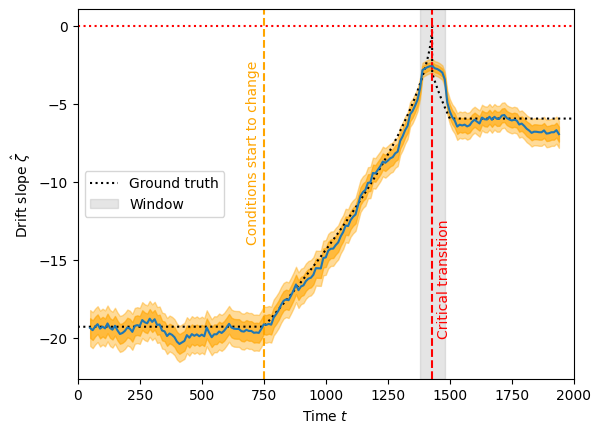

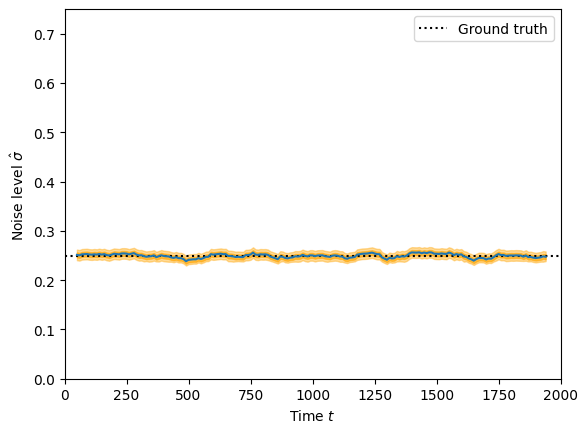

In [6]:
results = [langevin_model.slope_storage, langevin_model.noise_level_storage]
visualize_result(time, results, window_size, window_shift,visualize='both')

As we want to convince ourselves from the precision of the estimates, we align each of them to the mid point of the corresponding data window. Credible intervals (CIs) are shown in orange. Note that a time interval of one window length remains without any estimates due to the rolling windows of finite size (here one half at the beginning and one half at the end of the entire time range). In this simple example, the MAP estimation provides smooth and precise stability estimates, but deviates from the ground truth in direct vicinity of the transition. The reason is again given by the finite window size. This relationship is illustrated by the grey-shaded rolling window that is centered around the critical transition at time $t=1429$.

Large rolling windows limit the time resolution of the drift slope trend around the critical transition, as visible in the grey-shaded window. The theoretical zero-crossing is suppressed, as windows overlapping the transition data incorporate pre-, intra-, and post-transition data. This data mixture violates the stationarity assumption and leads to biased estimates. Therefore, in the next code block, we significantly reduce the window size and compare new to previous results.

In [7]:
window_size = 225
window_shift = 200 # Increasing window_shift decreases the total number of windows computed, 
                   # thereby reducing the overall computation time of the code block.

langevin_small_windows = ds.LangevinEstimation(data, time, detrending_of_whole_dataset='Gaussian kernel smoothed',
                                       gauss_filter_sigma=50)

langevin_small_windows.fast_MAP_resilience_scan(window_size=window_size, window_shift=window_shift, 
                                                error_propagation='uncorrelated Gaussian', print_progress=False)

HINT: Fixed cred_percentiles = numpy.array[5,1]) for the uncorrelated Gaussian error propagation of the drift slope is used for drift_model == `3rd_order_polynomial`.
Start parallel processing!
Parallel processing finished!


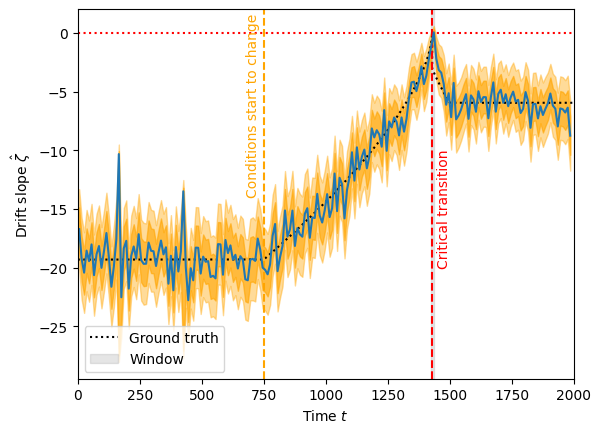

In [8]:
visualize_result(time, langevin_small_windows.slope_storage, window_size, window_shift, visualize='drift slope')

On the one hand, the time resolution of the drift slope is significantly improved in the transition area. Furthermore, the theoretically expected zero-crossing can be observed when the transition takes place. On the other hand, smaller time windows cause less precise estimates, as for example $\hat{\zeta}\approx -10$ around time $t=375$. In the worst case, the windows are too small to obtain reliable results. In such cases, *antiCPy*'s most reliable and flexible estimation procedure relies on Markov Chain Monte Carlo (MCMC) sampling, implemented in the [*emcee*](https://emcee.readthedocs.io/en/stable/) package. See also the article [emcee: The MCMC Hammer](https://doi.org/10.48550/arXiv.1202.3665) (Foreman-Mackey, Hogg, Lang, Goodman, arXiv (2013)). Furthermore, by using the MCMC procedure we can derive CIs directly from the posterior distributions, without additional assumptions.

However, since this MCMC sampling per window is computationally expensive (roughly 40 min on 20 CPU cores for 198 windows), a detailed evaluation is not suitable for this presentation. Instead, we limit ourselves to a total number of 20 windows and use Markov chains that are too short to reliably determine their correlation lengths. In real applications, all data whithin one correlation length must be neglected to obtain fully independent samples and thus unbiased statistics. Here, we ignore this issue, as the results already underline the robustness of the MCMC procedure for small rolling windows, even if the Markov chains are not fully converged. Moreover, we apply a linear detrending per window, instead of Gaussian kernel detrending over the entire dataset. The code below takes approximately 2.7 min on 5 CPU cores. Note that the missing values at the end are caused by the large window shift. With minimal print output, each CPU core announces its activity and finally reports the shape of the sample array before thinning.

In [9]:
import time as tt 

window_size = 500
window_shift_MCMC = 2031 # Increasing window_shift decreases the total number of windows computed, 
                         # thereby reducing the overall computation time of the code block.

langevin_model_MCMC = ds.LangevinEstimation(data,time)
alpha = tt.time()
langevin_model_MCMC.fast_resilience_scan(window_size=window_size, window_shift=window_shift_MCMC,
                                        nsteps=1000, ignore_AC_error=True, # IMPORTANT: Parameters only for illustration. 
                                                                           # See main text for details.
                                        slope_grid=np.linspace(-25,1,1000), # Grids for the posterior distributions
                                        noise_grid=np.linspace(0,0.5,100), # Grids for the posterior distributions
                                        num_processes=5, print_progress=False, 
                                        detrending_per_window='linear')
omega = tt.time()
print('Time elapsed: ' + str(omega-alpha) + ' s.')

Start parallel processing!
Parallel processing finished!
Time elapsed: 182.0823619365692 s.


(5, 20)


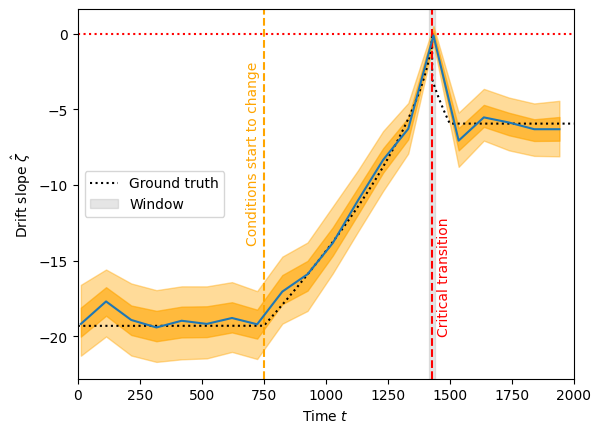

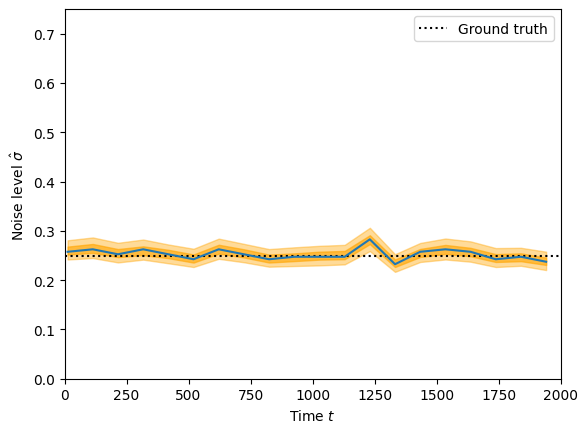

In [10]:
results = [langevin_model_MCMC.slope_storage, langevin_model_MCMC.noise_level_storage]
visualize_result(time, results, window_size, window_shift_MCMC, visualize='both')

For completeness, the detailed results for all 198 windows are shown in the graphs below. As visible, the MCMC procedure is more robust against small window sizes. The MAP estimation on windows of size 500 data points yields similar outliers as the evaluation on windows of size 225 data points that is shown above. We do not observe such outliers in the MCMC results, which are thus slightly more precise.

![Detailed MCMC results: drift slopes](figures/MCMC_slope_solution.png)
![Detailed MCMC results: noise levels](figures/MCMC_noise_solution.png)


## Trend-Change Point Analysis <a id="CP"></a>

This section presents the basics of how to use *antiCPy*'s implementation of a Bayesian linear segment fit (cf. von der Linden et al., *Bayesian Probability Theory. Applications in the Physical Sciences*. Cambridge University Press, 2014. ISBN: 978-1-107-
03590-4). This non-parametric fit connects linear trends of differing slopes at so-called (trend) change points (CPs) $E$, i.e., positions of significant trend changes. This Bayesian approach marginalizes over all possible CP configurations. It can be generally applied to (x,y)-data pairs. Here in particular, we illustrate the procedure on `langevin_small_windows`'s drift slopes. In our example, the procedure is advantageous, since it enables consistently extrapolating the fit and its CIs, here defined as $3\sigma$ intervals. Before we start, let us define a custom function to visualize the CP fit and the CP probability density functions (PDFs).

In [11]:
def visualize_CP_fit(x, y, fit_obj, data_end, thinning, num_CPs, fit_support, data_ylim, pdf_ylim):
    global critical_time
    ax = plt.subplot()
    ax.scatter(x[:data_end:thinning], y[:data_end:thinning], facecolors='none', edgecolors='r', label='Drift slopes')
    fit_time = np.linspace(fit_obj.x_start, fit_obj.prediction_horizon, fit_support)
    ax.plot(fit_time, fit_obj.D_array, label='Segment fit') # D_array contains the y ordinate of the fit
    ax.fill_between(fit_time, fit_obj.D_array-3*np.sqrt(fit_obj.DELTA_D2_array), # DELTA_D2_array contains the fit variance
                    fit_obj.D_array+3*np.sqrt(fit_obj.DELTA_D2_array), color='orange', 
                    alpha=0.5, label=r'$3\sigma$ CI')
    ax.plot([fit_time[0],fit_time[-1]],[0,0], color = 'red', ls=':')
    ax.axvline(critical_time, ls='--', color = 'red')
    ax.axvline(750, c='orange', ls='--')
    ax.text(755, -13, "Conditions start to change", rotation=90, c='orange', verticalalignment='bottom')
    ax.text(1435, -13, "Critical transition", rotation=90, c='red', verticalalignment='bottom')
    ax.set_xlim(fit_time[0], fit_time[-1])
    ax.set_ylim(data_ylim[0],data_ylim[1])
    ax.set_xlabel(r'Time $t$')
    ax.set_ylabel(r'Drift slopes $\hat{\zeta}$')
    pdf_axis = ax.twinx()
    line_style = ['-', ':', '--']
    CP_numbering = ['1st' ,'2nd','3rd']
    if num_CPs==1:
        CP_pdf = np.append([0],np.append(fit_obj.prob_cp, [0])) # Add leading/ending zero as no change point as no
                                                                # change point is allowed for start/end of the data.
        ax.plot([],[], color='k', label='1st CP PDF')
        pdf_axis.plot(x[:data_end:thinning], CP_pdf, color ='k', ls=line_style[0])
    elif num_CPs>1:
        for i in range(num_CPs):
            pdf_axis.plot(x[:data_end:thinning], fit_obj.CP_pdfs[i,:], color ='k', ls=line_style[i]) 
            ax.plot([],[], ls=line_style[i], color='k', label=CP_numbering[i] + ' CP PDF')
    pdf_axis.set_ylim(pdf_ylim[0],pdf_ylim[1])
    pdf_axis.set_ylabel(r'CP PDF $p(E\mid \hat{\zeta}, t)$')
    ax.legend()

Next, we import *antiCPy*'s parallelized `BatchedCPSegmentFit` object and prepare our data, i.e., the drift slope MAP estimates and their corresponding time stamps. A thinning is applied to avoid that dependent estimates enter the fit due to overlapping rolling windows, which would create biased fits.

Let us imagine an online setting, in which the data stream is continuously updated. Therefore, we introduce the `data_end` variable that artificially mimics the current end of the data stream. At first, we have only a few data points in the stable initial regime, but we expect that these stable dynamics may change in future. Hence, we assume that there is one trend CP present in the data. In the next two code blocks below, we define the object, perform the fit, and, finally, visualize the results.

In [12]:
from antiCPy.trend_extrapolation import BatchedCPSegmentFit

window_size = 225
window_shift = 200

drift_slopes = langevin_small_windows.slope_storage[0,:]
mod_time = time[int(window_size/2.)::window_shift] # Adapt the time array to match the estimates' time stamps

data_end = 75 # Fictitious number of points that are currently observed
num_CPs = 1
fit_support = 100 # Number of points computed for the CP fit
thinning = 2 # As the rolling windows overlap, the drift slopes should be 
             # thinned to obtain independent data for the fit.

One_CP = BatchedCPSegmentFit(mod_time[:data_end:thinning], drift_slopes[:data_end:thinning], 
                             number_expected_changepoints=num_CPs,num_MC_cp_samples=50000, 
                             predict_up_to=2200, z_array_size=fit_support)

One_CP.fit(print_progress=False)

MC sample proposal:  50000
Number of change point configurations:  36
Adapt batchsize!
Final batch size: 36
Total batches: 1
Less configurations than MC sample proposal. Compute exact sum!
Start parallel processing!
Parallel processing finished!
1 tasks of 1 are executed in round 1 of 1 round.


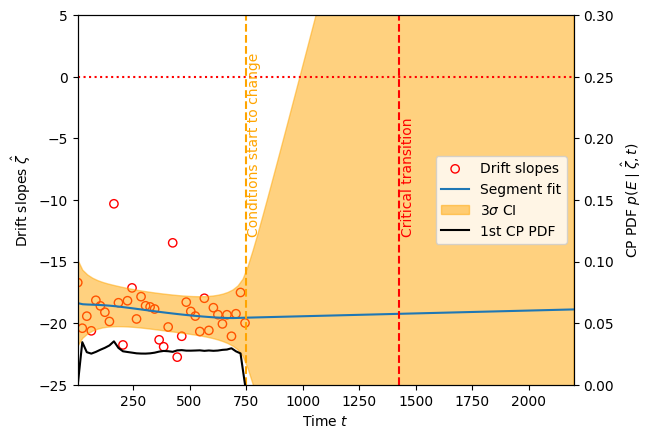

In [13]:
visualize_CP_fit(mod_time, drift_slopes, One_CP, data_end, thinning, num_CPs, fit_support, [-25,5], [0,0.3])

The Bayesian fit implemented in *antiCPy* allows for consistently extrapolating the fitted trends and their CIs into past and future. Briefly summarized, no significant trend CP is identified in the observed data. The CP PDF is almost flat over the observation interval and the future uncertainty grows fast. However, the fit does not cross the critical zero line, but  suggests almost stable drift slope values by the extrapolation. If the observation interval is slightly modified, but still in the stable initial regime, the extrapolation may be tilted slightly up and down, but no zero-crossing is observed.

Next, we consider a larger observation interval, incoporating the CP. As environmental changes are typically nonlinear, we cannot trust the linear extrapolation after observing one CP. Therefore, we assume that two CPs are present in the data to account for potential future changes.

In [16]:
window_size = 225
window_shift = 200

data_end = 120
num_CPs = 2
fit_support = 100
thinning = 2

Two_CPs = BatchedCPSegmentFit(mod_time[:data_end:thinning], drift_slopes[:data_end:thinning], 
                             number_expected_changepoints=num_CPs,num_MC_cp_samples=50000, 
                             predict_up_to=2200, z_array_size=fit_support)

Two_CPs.fit(print_progress=False)
Two_CPs.compute_CP_pdfs(print_progress=False) # Marginalization over the change point configurations

MC sample proposal:  50000
Number of change point configurations:  1653
Adapt batchsize!
Final batch size: 1653
Total batches: 1
Less configurations than MC sample proposal. Compute exact sum!
Start parallel processing!
Parallel processing finished!
1 tasks of 1 are executed in round 1 of 1 round.
1653 tasks of 1653 are executed.


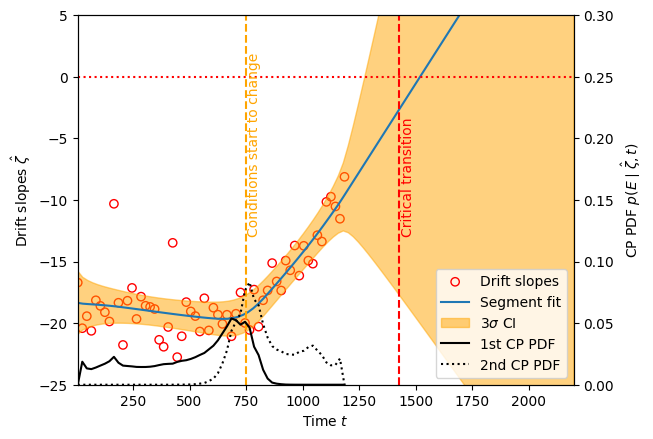

In [15]:
visualize_CP_fit(mod_time, drift_slopes, Two_CPs, data_end, thinning, num_CPs, fit_support, [-25,5], [0,0.3])

Now, the probability density mass clearly accumulates at the onset of changing conditions. In contrast to the short observation interval, the extrapolation clearly crosses the critical zero line in vicinity of the true transition. Furthermore, this transition is correctly included in the CIs. Note that the width of the CIs is correlated with the rolling window size of the drift slope estimation procedure. Large windows result into narrower CIs that may slightly fail to incorporate the true transition time. However, you may try to use `langevin_model`'s drift slopes computed on windows of size 2000 by adapting the parameters as follows:

* Replace `drift_slopes = langevin_small_windows.slope_storage[0,:]` by `drift_slopes = langevin_model.slope_storage[0,:]`,
* set `window_size=2000`,
* and use `thinning=10`.
    

## Summary and Outlook <a id="summary"></a>

In this tutorial, we only could address an exerpt of *antiCPy*'s toolbox. In particular, we discussed two prominent functionalities in more detail: first, the resilience analysis; and second, the Bayesian trend CP fit. In the following, we list key takeaways, refer to advanced functionalities, and conclude with some remarks. 

>💡 
> For standalone Python scripts, please remember to define the entry point using `if __name__ == "__main__":` under the package imports if you rely on *antiCPy*'s parallelized algorithms instead of using the serial counterparts.

### Resilience Analysis

Here are the **key takeaways**:

> 1. The drift slope as restoring rate towards a stable state can be estimated using *antiCPy*.
> 2. Detrending of the raw data can be crucial to obtain unbiased estimates of local window dynamics.
> 3. The window size is an important parameter. Small window estimates react fast to changing dynamics and improve the time resolution, which can be crucial within the transition interval. Larger windows lead to smooth trends and more stable estimates.
> 4. The MCMC estimation procedure outperforms the MAP estimation in terms of robustness and flexibility, but is significantly more time consuming. If computation times are a limiting factor, also consider the [binned MAP estimation procedure](https://anticpy.readthedocs.io/en/latest/early_warnings/drift_slope/drift_slope.html#antiCPy.early_warnings.drift_slope.binning_langevin_estimation.BinningLangevinEstimation).


Before we turn towards the Bayesian trend CP fit, the follwing list summarizes **related key functionalities and further reading**:

> 1. The `LangevinEstimation` object of *antiCPy* is complemented by the `NonMarkovEstimation` object. Whereas the `LangevinEstimation` model is one-dimensional and incorporates uncorrelated noise, the two-dimensional `NonMarkovEstimation` model accounts for correlated fast-scale dynamics, such as red noise, or slow hidden processes. This may be useful, e.g., in climate dynamics.
> 2. Even if the example data were simulated by a one-dimensional model, *antiCPy*'s resilience analysis can be successfully applied to high dimensional models, such as the three-dimensional ecological model considered in [Quantifying resilience and the risk of regime shifts under strong correlated noise](https://doi.org/10.1093/pnasnexus/pgac296) (Heßler & Kamps, PNAS Nexus (2023)). The choice of the system observable is crucial in this context.
> 3. The Bayesian resilience analysis is complemented by a dynamic empirical modelling approach that measures stability and classifies destabilization types (i.e., bifurcations; cf. [Excursion](#excursion)). See this [hands-on tutorial](https://anticpy.readthedocs.io/en/latest/early_warnings/dominant_eigenvalue/dominant_eigenvalue_tutorial.html) and the [math guide](https://anticpy.readthedocs.io/en/latest/early_warnings/dominant_eigenvalue/dominant_eigenvalue_maths.html) for more details.
> 4. See also the animation feature to create explanatory movies of *antiCPy*'s resilience analysis algorithm.

### Trend-Change Point Analysis

Here are the **key takeaways**:

> 1. The Bayesian trend CP fit, implemented in *antiCPy*, is a general approach for arbitrary (x,y)-coordinate pairs that may exhibit distinct intervals of linear trends.
> 2. The Bayesian fit incorporates all possible CP configurations, yields consistent CIs and marginalized CP PDFs, and can be extrapolated. 
> 3. It may be used to roughly extrapolate potential transition intervals based on the currently available drift slope estimates. Such extrapolations may be flexibly adapted if the data stream is updated.
> 4. For reliable results, small and non-overlapping windows should be used. This guarantees independent samples for the fit and fast reaction to changing dynamics.


## Excursion: Mathematical Model Insights <a id="excursion"></a>

The simple one-dimensional model 
$$
\dot{x}=h(x)=r+x-x^3
$$
lends itself to demonstrate *antiCPy*'s key functionalities. The model's destabilizing journey is determined by the control parameter $r$, which is changed over time. The system destabilizes through a fold bifurcation in which a stable and an unstable fixed point collide and annihilate each other. Thus, this bifurcation eliminates two of three fixed points and the system jumps to the last remaining stable branch. As $\dot{x}$ denotes the time evolution of $x$, a fixed point is defined by the condition
$$
h(x) \overset{!}{=} 0.
$$
The analytical solution can be derived by using Cardano's formula as a function of $r$. For $|r| \leq\frac{2}{3\sqrt{3}}$, three fixed points coexist and can be determined using Cardano's trigonometric formula. For $|r| >\frac{2}{3\sqrt{3}}$, a single fixed point remains, given by the hyperbolic form of Cardano's formula. The considered dataset is perturbed by white noise of constant level $g(x)=\sigma:= 0.25$. A realization of such a stochastic process can be computed by integrating a nonlinear Langevin equation
$$
\dot{x}=h(x)+g(x)\Gamma(t),
$$
where $\Gamma(t)$ represents Gaussian white noise, corresponding to uncorrelated random numbers in the discrete-time approximation of Wiener process increments. The integration can be performed using the Euler-Maruyama scheme.

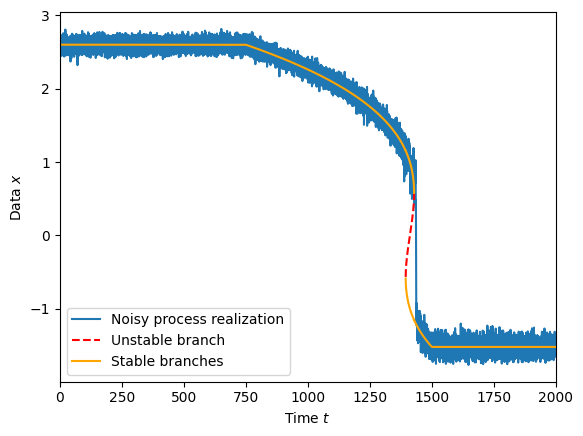

In [17]:
r = np.append(np.ones(15000)*15, np.append(np.linspace(15,-2,15000), np.ones(10000)*(-2))) # Control parameter

# Compute the analytical solutions in the interval where three fixed points coexist
branches = np.zeros((3,data.size))
for k in range(1,4):
    branches[k-1,np.where(np.abs(r)<=2./(3*np.sqrt(3)))] = 2*np.sqrt(1/3.)*np.cos((1/3.)*np.arccos((3*np.sqrt(3))/2*r[np.where(np.abs(r)<=2./(3*np.sqrt(3)))])-2*(np.pi*k)/3.)

# Compute the analytical solution in the intervals where a single fixed point exists
extended_branches = np.zeros((2,data.size))   
extended_branches[0,np.where(r>2./(3*np.sqrt(3)))] = 2*np.sqrt(1./3.)*np.cosh(1./3.*np.arccosh((3*np.sqrt(3))/2.*r[np.where(r>2./(3*np.sqrt(3)))]))
extended_branches[1,np.where(r<-2./(3*np.sqrt(3)))] = -2*np.sqrt(1./3.)*np.cosh(1./3.*np.arccosh(-(3*np.sqrt(3))/2.*r[np.where(r<-2./(3*np.sqrt(3)))]))

# Visualize mathematical details
plt.plot(time[np.where(r>2./(3*np.sqrt(3)))], extended_branches[0,np.where(r>2./(3*np.sqrt(3)))][0], c='orange')
color = ['red','orange', 'orange']
linestyle = [ '--','-', '-']
plt.plot(time, data, label='Noisy process realization')
plt.plot(time[np.where(r>2./(3*np.sqrt(3)))], extended_branches[0,np.where(r>2./(3*np.sqrt(3)))][0], c='orange')
for k in range(3):
    if k>0:
        plt.plot(time[np.where(branches[k,:]!=0)], branches[k,np.where(branches[k,:]!=0)][0], c=color[k], ls=linestyle[k])
    else:
        plt.plot(time[np.where(branches[k,:]!=0)], branches[k,np.where(branches[k,:]!=0)][0], c=color[k], ls=linestyle[k], label='Unstable branch')
plt.plot(time[np.where(r<-2./(3*np.sqrt(3)))], extended_branches[1,np.where(r<-2./(3*np.sqrt(3)))][0], c='orange', label='Stable branches')
plt.xlim(0, 2000)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Data $x$')
plt.legend()